In [1]:
import os
import time
import math
import random
import pickle
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import exrex
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from scipy.stats import kstest, ks_2samp, chi2_contingency, wasserstein_distance, norm
from scipy.interpolate import interp1d
# from sdv.datasets.demo import get_available_demos
from sdv.datasets.local import load_csvs
from sdv.datasets.demo import download_demo
from rdt import HyperTransformer
from tqdm import tqdm

In [2]:
set_verbosity(ERROR)

In [3]:
tf.random.set_seed(123)

In [4]:
# available_demo_df = get_available_demos(modality='multi_table')

In [5]:
# available_demo_df.sort_values(by=['size_MB', 'num_tables'], ascending=True)[available_demo_df['num_tables'].astype(int) >= 3][available_demo_df['num_tables'].astype(int) <= 10][available_demo_df['size_MB'].astype(int) <= 100]

In [6]:
real_data_collection, sdv_metadata = download_demo(
    modality='multi_table',
    dataset_name='university_v1'
)

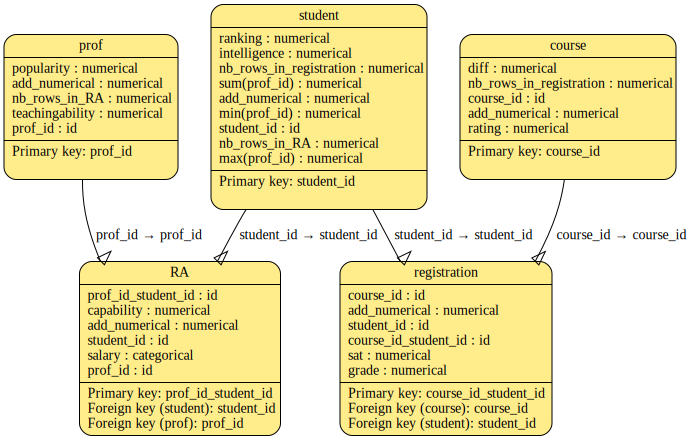

In [7]:
sdv_metadata.visualize(output_filepath='visualization/university.jpeg')

# Preprocessing

In [8]:
training_start_time = time.time()

## Create Modelling Metadata

Setup dictionary for identifying the primary key, parent(s), child(ren) and foreign key(s) of each table.

In [9]:
def sdvmetadata_to_modelmetadata(sdv_metadata):
    modelling_metadata = {}
    for df_name, content in sdv_metadata["tables"].items():
        modelling_metadata[df_name] = {
            "primary_key": content.get("primary_key"),
            "parent": {},
            "child": {},
            "is_sequential": False,
            "sort_order":None,
            "step_index":None
        }
    for relationship in sdv_metadata["relationships"]:
        parent_table = relationship["parent_table_name"]
        child_table = relationship["child_table_name"]
        foreign_key = relationship["child_foreign_key"]
        modelling_metadata[child_table]["parent"][parent_table] = foreign_key
        modelling_metadata[parent_table]["child"][child_table] = foreign_key
    return modelling_metadata

In [10]:
modelling_metadata = sdvmetadata_to_modelmetadata(sdv_metadata.to_dict())

## Fit RDT Transformers and Formatters

Use tools from RDT package to convert data to solely numeric and back-transforming to the original format.

In [11]:
def create_formatter_collection(data_collection):
    formatter_collection = {}
    for df_name, df in data_collection.items():
        ht = HyperTransformer()
        ht.detect_initial_config(df)
        ht.update_transformers_by_sdtype(
            sdtype='categorical',
            transformer_name='LabelEncoder'
        )
        # ht.update_transformers_by_sdtype(
        #     sdtype='datetime',
        #     transformer_name='OptimizedTimestampEncoder'
        # )
        # ht.update_transformers_by_sdtype(
        #     sdtype='numerical',
        #     transformer_name='FloatFormatter'
        # )
        ht.fit(df)
        formatter_collection[df_name] = ht
    return formatter_collection

In [12]:
%%time
formatter_collection = create_formatter_collection(real_data_collection)

CPU times: total: 172 ms
Wall time: 172 ms


## Transform Data to Numeric

In [13]:
def batch_transform(modelling_metadata, df_dict, ht_dict):
    # Initialize the dictionary that will store the mappings for each primary key
    primary_key_dict = {}

    # Initialize a new dictionary to store the transformed dataframes
    transformed_df_dict = {table: df.copy() for table, df in df_dict.items()}

    # Initialize the dictionary to store transform methods
    transform_method_dict = {table: {'labels': [], 'table': []} for table in df_dict.keys()}

    # 1st pass: Fit the HT objects for all tables
    for df_name, content in modelling_metadata.items():
        ht = ht_dict[df_name]
        ht.fit(transformed_df_dict[df_name])  # Fit the HT object on the entire table

    # 2nd pass: factorize primary keys and build the global primary key dictionary
    for df_name, content in modelling_metadata.items():
        primary_key = content['primary_key']
        if primary_key is not None:  # Skip tables without a primary key
            transformed_df_dict[df_name][primary_key], unique = pd.factorize(transformed_df_dict[df_name][primary_key])
            primary_key_dict[df_name] = {primary_key: {key: value for value, key in enumerate(unique)}}
            transform_method_dict[df_name]['labels'].append(primary_key)

    # 3rd pass: replace foreign keys using the primary key dictionary
    for df_name, content in modelling_metadata.items():
        for parent_table, foreign_key in content['parent'].items():
            primary_key = modelling_metadata[parent_table]['primary_key']
            transformed_df_dict[df_name][foreign_key] = transformed_df_dict[df_name][foreign_key].map(primary_key_dict[parent_table][primary_key])
            transform_method_dict[df_name]['labels'].append(foreign_key)

    # 4th pass: transform the remaining columns with the fitted HT objects
    for df_name, content in modelling_metadata.items():
        ht = ht_dict[df_name]
        df = transformed_df_dict[df_name]
        remaining_cols = [col for col in df.columns if col not in transform_method_dict[df_name]['labels']]
        if remaining_cols:
            df[remaining_cols] = ht.transform_subset(df[remaining_cols])  # Transform only the remaining columns
            transform_method_dict[df_name]['table'].extend(remaining_cols)

    return transformed_df_dict, transform_method_dict

In [14]:
%%time
transformed_data_collection, transform_method_dict = batch_transform(modelling_metadata, real_data_collection, formatter_collection)

CPU times: total: 93.8 ms
Wall time: 96 ms


## Split Tables into Discrete and Continuous Columns

In [15]:
def identify_columns(sdv_metadata, modelling_metadata):
    # Define the discrete types.
    discrete_sdtypes = ['categorical', 'id', 'boolean']

    # Iterate over the metadata.
    for df_name, content in sdv_metadata.items():
        grouped_columns = {'categorical': [], 'numeric': []}
        # Iterate over the columns of the DataFrame.
        for column_name, col_type in content['columns'].items():
            # If the column's 'sdtype' is one of the discrete types, add it to the 'discrete' group.
            if col_type['sdtype'] in discrete_sdtypes:
                grouped_columns['categorical'].append(column_name)
            # elif col_type['sdtype'] == 'numerical':
            #     if 'computer_representation' in col_type and 'Int' in col_type['computer_representation']:
            #         grouped_columns['discrete'].append(column_name)
            else:
                # Otherwise, add it to the 'continuous' group.
                grouped_columns['numeric'].append(column_name)
        modelling_metadata[df_name]['col_types'] = grouped_columns

In [16]:
identify_columns(sdv_metadata.to_dict()['tables'], modelling_metadata)

In [17]:
def split_continuous_discrete(data_collection, modelling_metadata):
    for df_name, content in modelling_metadata.items():
        foreign_columns = []
        label_columns = []
        selected_columns = []
        if content['parent'] != {}:
            foreign_columns = list(modelling_metadata[df_name]['parent'].values())
        discrete_columns = modelling_metadata[df_name]['col_types']['categorical']
        if content['primary_key'] != None:
            selected_columns = [col for col in discrete_columns if col != content['primary_key']]
        else:
            selected_columns = discrete_columns
        selected_columns = list(set(foreign_columns) | set(selected_columns))
        if content['step_index'] != None:
            selected_columns = list(set(content['step_index']) | set(selected_columns))
        if selected_columns != [] or None:
            modelling_metadata[df_name]['selected_columns'] = selected_columns
        else:
            modelling_metadata[df_name]['selected_columns'] = []

In [18]:
%%time
split_continuous_discrete(transformed_data_collection, modelling_metadata)

CPU times: total: 0 ns
Wall time: 0 ns


## Scaling

In [19]:
def get_min_max_range(df):
    min_max_range = {}
    for col in df.columns:
        min_ = df[col].min()
        max_ = df[col].max()
        min_max_range[col] = {'min':min_,'max':max_}
    return min_max_range

In [20]:
def normal_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [21]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    try:
        scaled_table, table_scaler = normal_scaling(table)
    except:
        scaled_table = None
        table_scaler = None
    scaled_labels, labels_scaler = normal_scaling(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [22]:
def batch_scaling(data_collection, modelling_metadata):
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        primary_key_column = modelling_metadata[df_name]['primary_key']
        if primary_key_column != None:
            label_columns = list(set([primary_key_column]) | set(selected_columns))
        else:
            label_columns = selected_columns
            primary_key_scaler = None
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels}
        backtransformation_dict[df_name] = {'table_scaler':table_scaler,
                                            'labels_scaler':labels_scaler,
                                       'table_col_names':table_columns,
                                       'labels_col_names':label_columns,
                                       'col_names':df.columns,
                                           'min_max_range':get_min_max_range(df[selected_columns])}
    return processed_data_collection, backtransformation_dict

In [23]:
%%time
processed_data_collection, backtransformation_dict = batch_scaling(transformed_data_collection, modelling_metadata)

CPU times: total: 15.6 ms
Wall time: 19 ms


# Modelling

## Fit KDE

In [24]:
def fit_kde(data, kernel='tophat', bandwidth='scott'):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(data)
    return kde

In [25]:
def batch_kde_fitting(data_collection, modelling_metadata):
    kde_collection = {}
    for df_name, df in data_collection.items():
        selected_columns = modelling_metadata[df_name]['selected_columns']
        if selected_columns != []:
            kde = fit_kde(df[selected_columns])
            kde_collection[df_name] = kde
    return kde_collection

In [26]:
%%time
kde_collection = batch_kde_fitting(transformed_data_collection, modelling_metadata)

CPU times: total: 0 ns
Wall time: 3 ms


## Build GAN

### Create Custom Functions for WGAN+GP Framework

In [27]:
def generator_loss(x_fake):
    return -tf.reduce_mean(x_fake)

In [28]:
def discriminator_loss(x_real, x_fake):
    real_loss = tf.reduce_mean(x_real)
    fake_loss = tf.reduce_mean(x_fake)
    return fake_loss - real_loss

In [29]:
def gradient_penalty(batch_size, real_table, fake_table, real_labels, discriminator, window=None):
    alpha = np.random.normal(0, 1, [batch_size, window, real_table.shape[2]])
    diff = tf.convert_to_tensor(fake_table) - real_table
    interpolated_table = real_table + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_table)
        pred = discriminator([interpolated_table,real_labels], training=True)

    grads = gp_tape.gradient(pred, [interpolated_table])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [30]:
class CustomSlidingWindow:
    def __init__(self, window_size):
        self.window_size = window_size

    def transform(self, data):
        shape = (data.shape[0] - self.window_size + 1, self.window_size) + data.shape[1:]
        strides = (data.strides[0],) + data.strides
        return as_strided(data, shape=shape, strides=strides)

    def inverse_transform(self, data, use_mean=False):
        if use_mean:
            rows, _, cols = data.shape
            output = np.zeros((rows+self.window_size-1, cols))
            count = np.zeros((rows+self.window_size-1, cols))
            
            for i, window in enumerate(data):
                for j, row in enumerate(window):
                    output[i+j] += row
                    count[i+j] += 1

            return output / count
        else:
            return data[:, 0, :]

### Define Plotting Function For G/D Loss

In [31]:
def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='GLoss')
        axes[i].plot(discriminator_log, label='DLoss')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

### Define Generator, discriminator and GAN Architecture

In [32]:
def build_conv_generator(table_dim, labels_dim, window, opt, loss, latent_dim=100):
    noise_input = layers.Input(shape=(window,latent_dim,))
    labels_input = layers.Input(shape=(window,labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    hidden_layer1 = layers.Conv1DTranspose(256,kernel_size=3,activation='relu',kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=4,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(64,kernel_size=5,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(32,kernel_size=6,activation='relu',kernel_initializer='he_normal',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    output_layer = layers.Conv1DTranspose(table_dim,kernel_size=1,activation='linear',kernel_initializer='glorot_normal')(bn_layer4)
    generator = models.Model([noise_input, labels_input], output_layer)
    generator.compile(optimizer=opt, loss=loss)
    return generator

In [33]:
def build_conv_discriminator(table_dim, labels_dim, window, opt, loss):
    table_input = layers.Input(shape=(window,table_dim,))
    labels_input = layers.Input(shape=(window,labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    hidden_layer1 = layers.Conv1D(32,kernel_size=6,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(merge_input)
    bn_layer1 = layers.BatchNormalization()(hidden_layer1)
    dropout1 = layers.Dropout(0.3)(bn_layer1)
    hidden_layer2 = layers.Conv1D(64,kernel_size=5,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    dropout2 = layers.Dropout(0.3)(bn_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=4,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer3)
    dropout3 = layers.Dropout(0.3)(bn_layer3)
    hidden_layer4 = layers.Conv1D(256,kernel_size=3,activation=layers.LeakyReLU(0.2),kernel_initializer='he_normal',padding='same')(dropout3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer4)
    dropout4 = layers.Dropout(0.3)(bn_layer4)
    flatten = layers.Flatten()(dropout4)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='glorot_normal')(flatten)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(optimizer=opt, loss=loss)
    return discriminator

### Define Training Strategy

In [34]:
def train_gan(name, real_table, real_labels, window, n_discriminator=5, gp_weight=10, epochs=50, patience=10, min_delta=0.1, batch_size=400, latent_dim=100, seed=123):
    rand_seed = seed
    csw = CustomSlidingWindow(window)
    real_table = csw.transform(real_table.values)
    real_labels = csw.transform(real_labels.values)
    half_batch = int(batch_size/2)
    g_opt = optimizers.Adam()
    d_opt = optimizers.Adam()
    g_loss_func = generator_loss
    d_loss_func = discriminator_loss
    generator = build_conv_generator(real_table.shape[2], real_labels.shape[2], window=window, opt=g_opt, loss=g_loss_func, latent_dim=latent_dim)
    discriminator = build_conv_discriminator(real_table.shape[2], real_labels.shape[2], window=window, opt=d_opt, loss=d_loss_func)

    generator_logs = []
    discriminator_logs = []
    
    for epoch in tqdm(range(epochs), desc="Training Numeric GAN"):
        # start_time = time.time()
        
        # train discriminator:
        for _ in range(n_discriminator):
            np.random.seed(rand_seed)
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            x_real_labels = real_labels[idx,:,:]
            x_real_table = real_table[idx,:,:]
            with tf.GradientTape() as tape:
                noise = np.random.normal(0, 1, (half_batch, window, latent_dim))
                x_fake_table = generator([noise, x_real_labels], training=True)
                d_logits_real = discriminator([x_real_table, x_real_labels], training=True)
                d_logits_fake = discriminator([x_fake_table, x_real_labels], training=True)
                d_cost = d_loss_func(d_logits_real, d_logits_fake)
                gp = gradient_penalty(half_batch, x_real_table, x_fake_table, x_real_labels, discriminator, window=window)
                d_loss = d_cost + gp * gp_weight
                rand_seed += 1
                
            d_grad = tape.gradient(d_loss, discriminator.trainable_variables)
            d_opt.apply_gradients(
                zip(d_grad, discriminator.trainable_variables)
            )
        d_loss = np.mean(d_loss)
        
        np.random.seed(rand_seed)
        # train generator/GAN
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        x_real_labels = real_labels[idx,:,:]
        x_gan = np.random.normal(0, 1, (batch_size, window, latent_dim))
        with tf.GradientTape() as tape:
            x_fake_table = generator([x_gan, x_real_labels], training=True)
            g_logits = discriminator([x_fake_table, x_real_labels], training=True)
            g_loss = g_loss_func(g_logits)
        g_grad = tape.gradient(g_loss, generator.trainable_variables)
        g_opt.apply_gradients(
            zip(g_grad, generator.trainable_variables)
        )
        generator_logs.append(g_loss)
        discriminator_logs.append(d_loss)
        
        rand_seed += 1
        
    generator.save('bm_models/university_models/'+name+'_gen.h5')
    
    return generator_logs, discriminator_logs

In [35]:
def collection_training(processed_collection, modelling_metadata, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning Numeric Columns in \"{df_name}\"...')
        latent_dim = 100
        if content['table'] is not None:
            window=6
            modelling_metadata[df_name]['window'] = window
            generator_log, discriminator_log = train_gan(df_name,
                                                             content['table'],
                                                             content['labels'],
                                                             window=window,
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim)
            logs.append([df_name, generator_log, discriminator_log])
            in_loop_elapsed_time = time.time() - start_time
            minutes, seconds = divmod(in_loop_elapsed_time, 60)
            print("Time Used: %dm %ds." % (minutes, seconds))
        else:
            modelling_metadata[df_name]['window'] = 0
            print("Skipped (fully-categorical table, fitted with KDE instead).")
        print()
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [36]:
def calculate_epochs(data_collection, batch_size=400):
    parameter_dict = {}
    for df_name, df in data_collection.items():
        epochs = len(df) / batch_size
        if epochs < 20:
            epochs = 20
        elif epochs > 500:
            epochs = 500
        parameter_dict[df_name] = {'epochs':round(epochs)}
    return parameter_dict

In [37]:
training_parameter_dict = calculate_epochs(transformed_data_collection)

In [38]:
training_parameter_dict

{'RA': {'epochs': 20},
 'course': {'epochs': 20},
 'prof': {'epochs': 20},
 'registration': {'epochs': 20},
 'student': {'epochs': 20}}

Learning Numeric Columns in "RA"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


Time Used: 0m 16s.

Learning Numeric Columns in "course"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Time Used: 0m 12s.

Learning Numeric Columns in "prof"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


Time Used: 0m 12s.

Learning Numeric Columns in "registration"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.60it/s]


Time Used: 0m 12s.

Learning Numeric Columns in "student"...


Training Numeric GAN: 100%|████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.60it/s]


Time Used: 0m 12s.



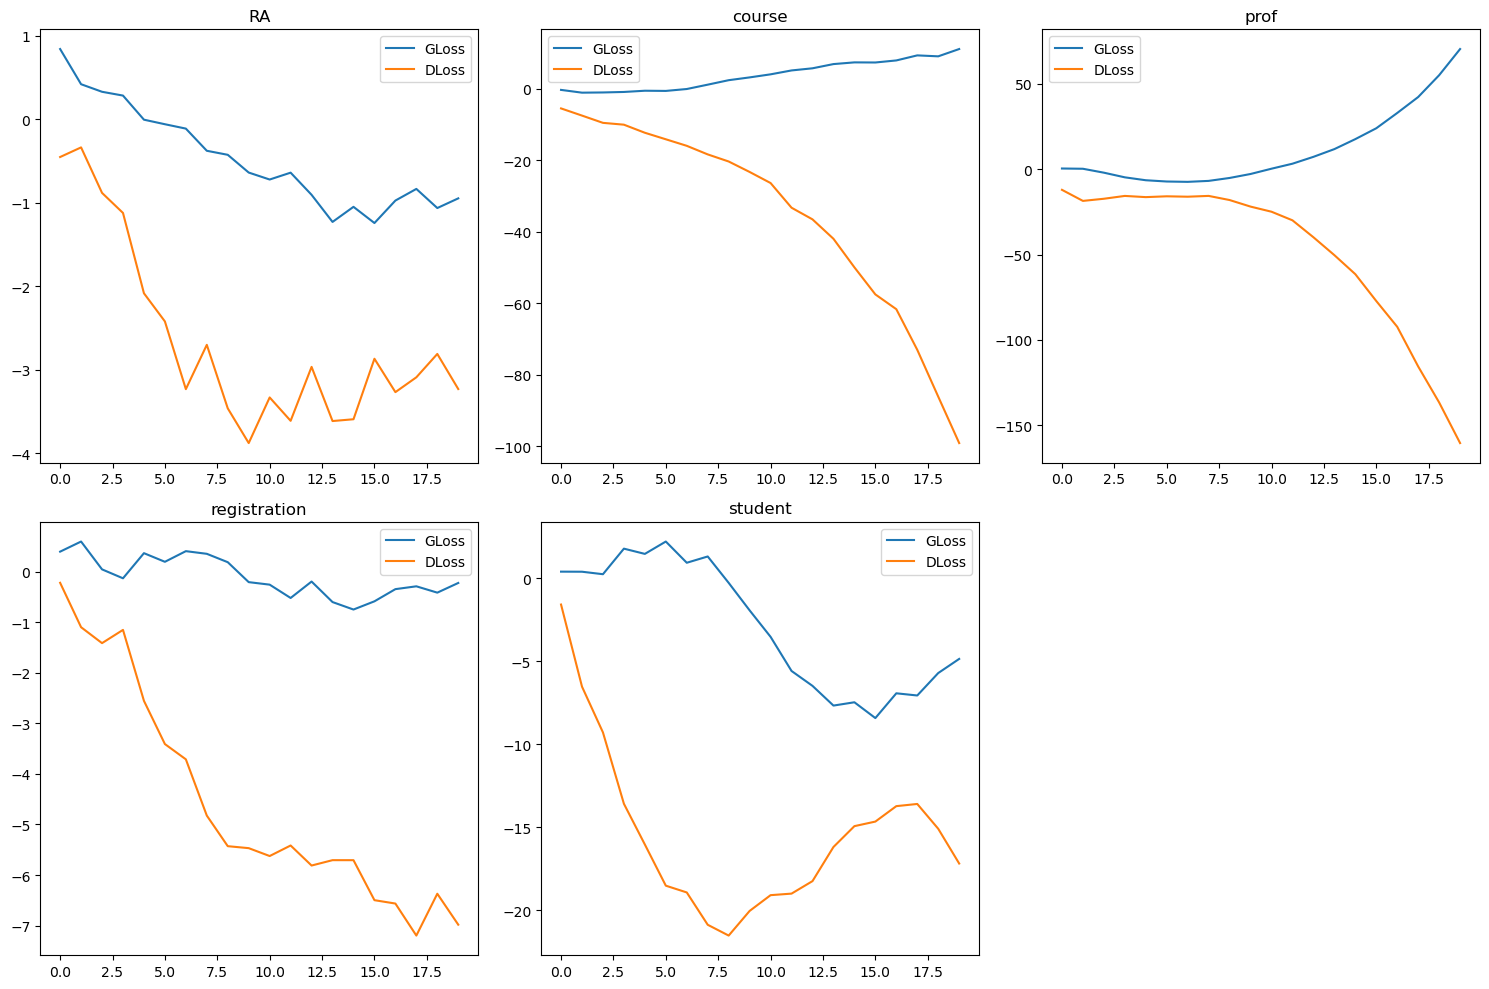

Total Time Used: 1m 7s
CPU times: total: 1min 6s
Wall time: 1min 7s


In [39]:
%%time

collection_training(processed_data_collection, modelling_metadata, training_parameter_dict)

In [40]:
training_end_time = time.time()
training_end_time = training_end_time - training_start_time
minutes, seconds = divmod(training_end_time, 60)
print(f'Total Training Time: {minutes}m {seconds}s.')

Total Training Time: 1.0m 8.484482049942017s.


In [41]:
generation_start_time = time.time()

# Synthetic Data Generation

## Set the number of rows to generate.

In [42]:
generation_dict = {k:{'nrows':len(v['labels'])} for k,v in processed_data_collection.items()}

In [43]:
generation_dict

{'RA': {'nrows': 25},
 'course': {'nrows': 10},
 'prof': {'nrows': 6},
 'registration': {'nrows': 92},
 'student': {'nrows': 38}}

## Define Interpolation Function

In [44]:
# def adjust_unique_elements(data, min_max_range, ignore=[]):
#     for col, range_ in min_max_range.items():
#         if col not in ignore:
#             data[col] = data[col]
#             min_val, max_val = data[col].min(), data[col].max()
#             original_range = np.linspace(min_val, max_val, len(data))
#             new_range = np.arange(range_['min'],range_['max'])
#             interp_func = interp1d(original_range, new_range, kind='nearest', bounds_error=False, fill_value=(range_['min'], range_['max']))
#             data[col] = interp_func(data[col]).astype(int)
#     return data

In [45]:
def adjust_unique_elements(df, min_max_range, ignore=[]):
    df_scaled = df.copy()
    for col, range_ in min_max_range.items():
        if col not in ignore:
            interpolator = interp1d([df[col].min(), df[col].max()], [range_['min'], range_['max']], kind='slinear', fill_value=(range_['min'], range_['max']))
            df_scaled[col] = interpolator(df[col]).round()
    return df_scaled

## Define KDE Sampling Strategy

In [46]:
def generate_labels(kde, n_samples, col_names, round_=False):
    new_data = kde.sample(n_samples)
    if round_:
        new_data_df = pd.DataFrame(new_data, columns=col_names).round()
    else:
        new_data_df = pd.DataFrame(new_data, columns=col_names)
    return new_data_df

## Generate Synthetic Data

In [47]:
def generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    custom_objects = {'generator_loss':generator_loss}
    for df_name, content in modelling_metadata.items():
        if len(backtransformation_dict[df_name]['table_col_names']) != 0:
            generator = models.load_model('bm_models/university_models/'+df_name+'_gen.h5', custom_objects=custom_objects)
        else:
            generator = None
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        n_samples = generation_dict[df_name]['nrows']
        window = content['window']
        
        print(f"Generating {df_name} (size={n_samples})...")
        
        fake_primary_key = None
        fake_selected_columns = None
        if primary_key != None:
            fake_primary_key = np.arange(n_samples)
            fake_primary_key = pd.DataFrame({primary_key:fake_primary_key})
            
        if content['selected_columns'] != []:
            kde = kde_collection[df_name]
            print(f"Generating Key and Categorical Columns...")
            kde_start_time = time.time()
            fake_selected_columns = generate_labels(kde, n_samples, content['selected_columns'])
            kde_elapsed_time= time.time() - kde_start_time
            minutes, seconds = divmod(kde_elapsed_time, 60)
            print("Key and Categorical Columns Generated: %dm %ds." % (minutes, seconds))
            min_max_range = backtransformation_dict[df_name]['min_max_range']
            if parent != None:
                for parent_table, f_keys in parent.items():
                    min_max_range[f_keys] = {'min':0,'max':generation_dict[parent_table]['nrows']-1}
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
            else:
                fake_selected_columns = adjust_unique_elements(fake_selected_columns, min_max_range)
        
        if fake_primary_key is not None:
            if fake_selected_columns is not None:
                fake_labels = pd.concat([fake_primary_key, fake_selected_columns], axis=1)
            else:
                fake_labels = fake_primary_key
        else:
            fake_labels = fake_selected_columns
        
        fake_labels = fake_labels.reindex(columns=backtransformation_dict[df_name]['labels_col_names'])
        if content['is_sequential'] == True:
            fake_labels = fake_labels.sort_values(by=content['sort_order'])
            
        scaled_fake_labels = backtransformation_dict[df_name]['labels_scaler'].transform(fake_labels)
        
        if generator is not None:
            latent_dim = 100
            noise = np.random.normal(0, 1, size=(n_samples-window+1, window, latent_dim))
            print(f"Generating Numeric Columns...")
            generator_start_time=time.time()
            sw = CustomSlidingWindow(window)
            scaled_fake_labels = sw.transform(scaled_fake_labels)
            raw_fake_table = generator.predict([noise, scaled_fake_labels], verbose=1)
            raw_fake_table = sw.inverse_transform(raw_fake_table, use_mean=True)
            fake_table = backtransformation_dict[df_name]['table_scaler'].inverse_transform(raw_fake_table)
            fake_table = pd.DataFrame(fake_table, columns=backtransformation_dict[df_name]['table_col_names'])
            fake_data = pd.concat([fake_labels.iloc[:n_samples], fake_table], axis=1)
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
            generator_elapsed_time= time.time() - generator_start_time
            minutes, seconds = divmod(generator_elapsed_time, 60)
            print("Numeric Columns Generated: %dm %ds." % (minutes, seconds))
        else:
            fake_data = fake_labels.iloc[:n_samples]
            fake_subset = formatter_collection[df_name].reverse_transform_subset(fake_data[transform_method_dict[df_name]['table']])
            fake_data = pd.concat([fake_data[transform_method_dict[df_name]['labels']], fake_subset], axis=1)
        fake_data = fake_data.reindex(columns=backtransformation_dict[df_name]['col_names'])
        synthetic_data_collection[df_name] = fake_data
        print()
    return synthetic_data_collection

In [48]:
%%time

synthetic_data_collection = generate_synth_data_collection(kde_collection, modelling_metadata, generation_dict, backtransformation_dict, formatter_collection, transform_method_dict)

Generating RA (size=25)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
1/1 [==============================] - 0s 422ms/step
Numeric Columns Generated: 0m 0s.

Generating course (size=10)...
Generating Numeric Columns...
1/1 [==============================] - 0s 315ms/step
Numeric Columns Generated: 0m 0s.

Generating prof (size=6)...
Generating Numeric Columns...
1/1 [==============================] - 0s 320ms/step
Numeric Columns Generated: 0m 0s.

Generating registration (size=92)...
Generating Key and Categorical Columns...
Key and Categorical Columns Generated: 0m 0s.
Generating Numeric Columns...
3/3 [==============================] - 0s 60ms/step
Numeric Columns Generated: 0m 0s.

Generating student (size=38)...
Generating Numeric Columns...
2/2 [==============================] - 0s 15ms/step
Numeric Columns Generated: 0m 0s.

CPU times: total: 3.06 s
Wall time: 2.99 s


## Generate/Replace Key Columns with Regular Expression

In [49]:
def replace_keys_with_regex(dataframes, metadata):
    # Generate a mapping from old primary keys to new ones for each table
    primary_key_mappings = {}
    for df_name, content in metadata['tables'].items():
        df = dataframes[df_name]

        # Skip tables without a primary key
        if 'primary_key' not in content:
            continue

        primary_key = content['primary_key']

        # Skip columns without a regex_format
        if 'regex_format' not in content['columns'][primary_key]:
            continue

        regex = content['columns'][primary_key]['regex_format']

        # Generate new primary keys
        regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Check if new keys are unique. If not, regenerate.
        while len(regex_primary_keys) != len(set(regex_primary_keys)):
            regex_primary_keys = [exrex.getone(regex) for _ in range(len(df))]

        # Create a mapping from old primary keys to new ones
        primary_key_mappings[df_name] = dict(zip(df[primary_key], regex_primary_keys))

        # Replace the primary keys in the original dataframe
        df[primary_key] = regex_primary_keys

    # Update the foreign keys in each table
    for relationship in metadata['relationships']:
        parent_df_name = relationship['parent_table_name']
        child_df_name = relationship['child_table_name']
        child_foreign_key = relationship['child_foreign_key']

        # Get the mapping from old to new primary keys for the parent table
        key_mapping = primary_key_mappings.get(parent_df_name)

        # If there's no key mapping (i.e., the parent table has no primary key),
        # skip this relationship
        if key_mapping is None:
            continue

        # Replace the foreign keys in the child table
        dataframes[child_df_name][child_foreign_key] = dataframes[child_df_name][child_foreign_key].map(key_mapping)

    return dataframes

In [50]:
%%time
synthetic_data_collection = replace_keys_with_regex(synthetic_data_collection, sdv_metadata.to_dict())

CPU times: total: 15.6 ms
Wall time: 15 ms


In [51]:
generation_end_time = time.time()
generation_end_time = generation_end_time - generation_start_time
minutes, seconds = divmod(generation_end_time, 60)
print(f'Total Generation Time: {minutes}m {seconds}s.')

Total Generation Time: 0.0m 3.1667239665985107s.


In [52]:
with open('pkl/university/university.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [53]:
with open('pkl/university/university_synth_full_epoch.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [54]:
with open('pkl/university/university_sdvmetadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)